## _*H2 excited states from EOM VQE*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state and excited state energies of the Hydrogen (H2) molecule over a range of inter-atomic distances using QEomVQE as discussed in [1].

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

[1] Ollitrault _et al_. (2019) [Quantum equation of motion for computing molecular excitation energies on a noisy quantum processor](https://arxiv.org/abs/1910.12890)

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import SwapRZ
from qiskit.chemistry.algorithms import QEomVQE
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD

Couldn't find cython int routine
Couldn't find cython int routine


First we compute reference values using ExactEigensolver. This notebook also utilizes the fact that when two_qubit_reduction is used with the parity mapping on H2 the resultant hamiltionian solely contains the 4 states we are looking for so that it is easy to generate reference values using ExactEigensolver.

In [2]:
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'

start = 0.5  # Start distance
by    = 1.5  # How much to increase distance by
steps = 30   # Number of steps to increase by
energies  = np.empty([4, steps+1])
distances = np.empty(steps+1)

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True)
    qubit_op, _ = operator.run(qmolecule)
    result = ExactEigensolver(qubit_op, k=4).run()
    _, result = operator.process_algorithm_result(result)
    energies[:, i] = result['energies']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)

Processing step 30 --- complete
Distances:  [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15
 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85
 1.9  1.95 2.  ]
Energies: [[-1.05515979 -1.09262991 -1.11628601 -1.12990478 -1.13618945 -1.13711707
  -1.13414767 -1.12836188 -1.12056028 -1.11133942 -1.10115033 -1.09034218
  -1.07919294 -1.06792966 -1.05674075 -1.04578314 -1.03518627 -1.02505436
  -1.01546825 -1.00648693 -0.99814935 -0.99047634 -0.98347273 -0.97712962
  -0.97142669 -0.96633454 -0.96181695 -0.95783297 -0.95433885 -0.95128976
  -0.94864111]
 [-0.07074011 -0.20191839 -0.31096009 -0.402052   -0.47845306 -0.5427821
  -0.5971778  -0.64339155 -0.68284939 -0.71670221 -0.74587179 -0.77109432
  -0.7929597  -0.81194535 -0.82844335 -0.8427812  -0.85523694 -0.86604987
  -0.87542794 -0.88355305 -0.89058478 -0.89666333 -0.90191182 -0.90643829
  -0.91033743 -0.91369215 -0.91657491 -0.91904902 -0.92116973 -0.92298519
  -0.92453732]
 [ 0.26700034  0.1

The excited states are now computed using QEomVQE algorithm. This uses an equation-of-motion algorithm, with the ground state as computed by VQE, to compute excited states.

In [3]:
aqua_globals.random_seed = 50
energies_eom = np.empty([4, steps+1])

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True)
    qubit_op, _ = operator.run(qmolecule)
    initial_state = HartreeFock(qubit_op.num_qubits,
                                num_orbitals=operator.molecule_info['num_orbitals'],
                                num_particles=operator.molecule_info['num_particles'],
                                qubit_mapping=operator._qubit_mapping,
                                two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(qubit_op.num_qubits, depth=1,
                     num_orbitals=operator.molecule_info['num_orbitals'],
                     num_particles=operator.molecule_info['num_particles'],
                     initial_state=initial_state,
                     qubit_mapping=operator._qubit_mapping,
                     two_qubit_reduction=operator._two_qubit_reduction)
    algo = QEomVQE(qubit_op,
                   var_form,
                   COBYLA(maxiter=10000),
                   num_orbitals=operator.molecule_info['num_orbitals'],
                   num_particles=operator.molecule_info['num_particles'],
                   qubit_mapping=operator._qubit_mapping,
                   two_qubit_reduction=operator._two_qubit_reduction)
    result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                      seed_simulator=aqua_globals.random_seed,
                                      seed_transpiler=aqua_globals.random_seed))
    _, result = operator.process_algorithm_result(result)
    energies_eom[:, i] = result['energies']
print(' --- complete')

print('Energies:', energies_eom)

Processing step 30 --- complete
Energies: [[-1.05515977 -1.09262989 -1.11628599 -1.12990477 -1.13618945 -1.13711706
  -1.13414766 -1.12836187 -1.12056028 -1.11133941 -1.10115032 -1.09034217
  -1.07919293 -1.06792965 -1.05674074 -1.04578313 -1.03518626 -1.02505436
  -1.01546824 -1.00648692 -0.99814935 -0.99047633 -0.98347272 -0.9771296
  -0.97142667 -0.96633449 -0.96181693 -0.95783293 -0.95433881 -0.95128975
  -0.94864109]
 [-0.07073514 -0.20195081 -0.31093056 -0.40205538 -0.47843676 -0.54276356
  -0.59714953 -0.64340217 -0.68284134 -0.71672299 -0.7458399  -0.77111516
  -0.79290413 -0.81191974 -0.82845482 -0.84272492 -0.85522434 -0.86605303
  -0.87546442 -0.88362384 -0.89053278 -0.89659817 -0.90192401 -0.90635547
  -0.9102725  -0.91364281 -0.91648663 -0.91904962 -0.92107712 -0.9229292
  -0.92456189]
 [ 0.26700531  0.14053823  0.03653073 -0.04941847 -0.12043561 -0.17922049
  -0.22789596 -0.26827847 -0.30169795 -0.32942236 -0.35225873 -0.37114662
  -0.38645966 -0.39893039 -0.40887188 -0.4

We now plot graphs of the results from QEomVQE and comparison against the reference values computed above using the ExactEigensolver

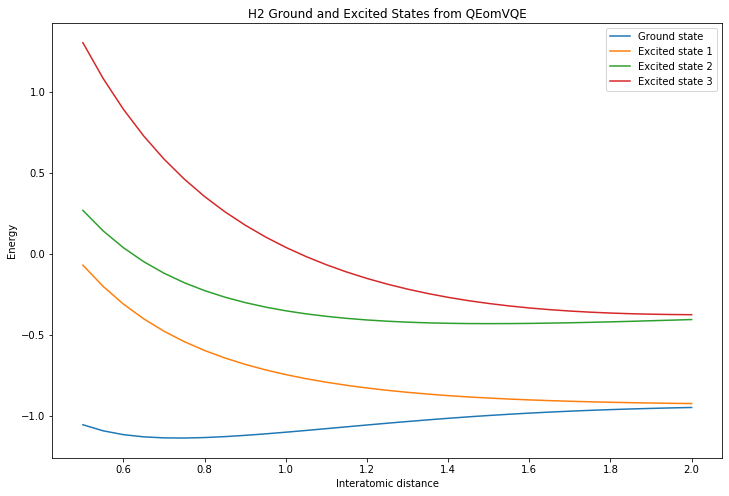

In [4]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(energies_eom.shape[0]):
    label = 'Ground state' if j ==0 else 'Excited state {}'.format(j)
    pylab.plot(distances, energies_eom[j], label=label)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground and Excited States from QEomVQE')
pylab.legend(loc='upper right')
pylab.show()

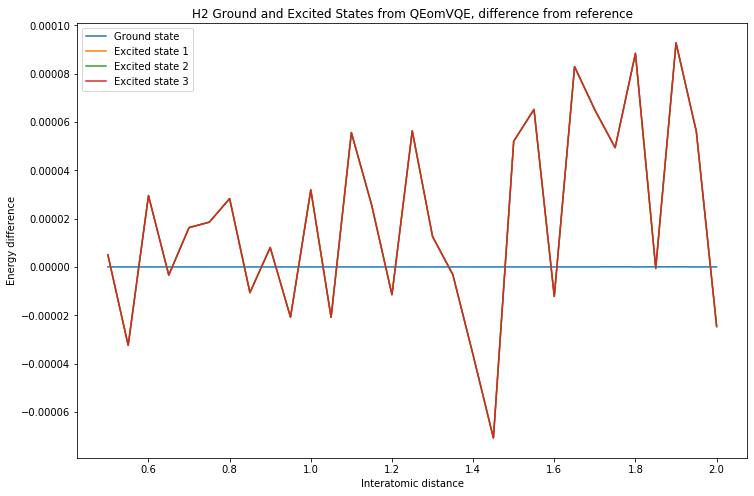

In [5]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(energies_eom.shape[0]):
    label = 'Ground state' if j ==0 else 'Excited state {}'.format(j)
    pylab.plot(distances, np.subtract(energies_eom[j], energies[j]), label=label)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy difference')
pylab.title('H2 Ground and Excited States from QEomVQE, difference from reference')
pylab.legend(loc='best')
pylab.show()

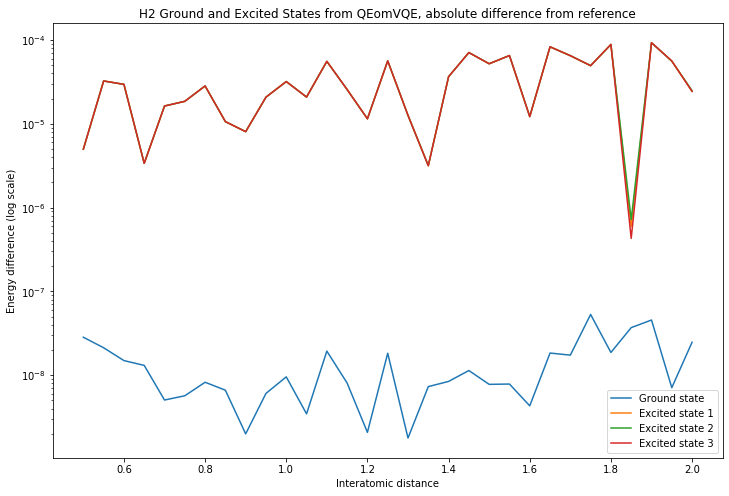

In [6]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(energies_eom.shape[0]):
    label = 'Ground state' if j ==0 else 'Excited state {}'.format(j)
    pylab.plot(distances, np.abs(np.subtract(energies_eom[j], energies[j])), label=label)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy difference (log scale)')
pylab.yscale('log')
pylab.title('H2 Ground and Excited States from QEomVQE, absolute difference from reference')
pylab.legend(loc='best')
pylab.show()